<h2>Importing the libraries</h2>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,recall_score,precision_recall_curve
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MaxAbsScaler, RobustScaler, PowerTransformer
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential   
from tensorflow.keras import layers  
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import backend
import random

In [ ]:
def load_df(file):
    import pandas as pd
    df = pd.read_csv(file)
    print(f"shape of loaded dataframe: {df.shape}")
    return df

def summary_stat(df):    
    import pandas as pd
    import numpy as np
    pd.set_option("display.max_columns", None)
    columns = []
    datatypes = []
    counts = []
    nas = []
    miss_pct = []
    uniques = []
    means = []
    stds = []
    maxs = []
    q3s = []
    medians = []
    q1s = []
    mins = []
    upper_whiskers = []
    lower_whiskers = []
    upper_outliers = []
    lower_outliers = []
    outlier_counts = []
    outlier_pcts = []
    modes = []
    for col in df.columns:
        columns.append(col)
        datatypes.append(df[col].dtypes)
        counts.append(df[col].count())
        nas.append(df[col].isna().sum())
        miss_pct.append(round(df[col].isna().sum() / len(df) * 100, 2))
        uniques.append(len(np.unique(df[col][~pd.isnull(df[col])])))
        if df[col].count() > 0: 
            modes.append((np.unique(df[col][~pd.isnull(df[col])]))[(np.argmax(np.unique(df[col][~pd.isnull(df[col])], return_counts = True)[1]))])
            if np.issubdtype(df[col].dtype, np.number):
                Q3 = np.nanquantile(df[col],0.75)
                Q1 = np.nanquantile(df[col],0.25)
                IQR = Q3 - Q1
                if IQR != 0:
                    upper_whisker = np.nanmax(df[df[col] < Q3 + 1.5*IQR][col].values)
                    lower_whisker = np.nanmin(df[df[col] > Q1 - 1.5*IQR][col].values)
                else : upper_whisker, lower_whisker = Q3,Q1
                outlier_upper_list = list(df[df[col] > upper_whisker][col].values)
                outlier_lower_list = list(df[df[col] < lower_whisker][col].values)
                upper_outliers.append(len(outlier_upper_list))
                lower_outliers.append(len(outlier_lower_list))
                outlier_counts.append(len(outlier_upper_list) + len(outlier_lower_list))
                means.append(np.round(np.mean(df[col]),3))
                stds.append(np.round(np.std(df[col]),3))
                maxs.append(np.nanmax(df[col]))
                q3s.append(Q3)
                medians.append(np.nanmedian(df[col]))
                q1s.append(Q1)
                mins.append(np.nanmin(df[col]))
                upper_whiskers.append(upper_whisker)
                lower_whiskers.append(lower_whisker)
                outlier_pcts.append(f"{np.round((len(outlier_upper_list) + len(outlier_lower_list))/len(df[col])*100, 2)} %")
            else :
                upper_outliers.append(" ")
                lower_outliers.append(" ")
                outlier_counts.append(" ")
                means.append(" ")
                stds.append(" ")
                maxs.append(" ")
                q3s.append(" ")
                medians.append(" ")
                q1s.append(" ")
                mins.append(" ")
                upper_whiskers.append(" ")
                lower_whiskers.append(" ")
                outlier_pcts.append(" ")
        else:
            means.append(" ")
            stds.append(" ")
            maxs.append(" ")
            q3s.append(" ")
            medians.append(" ")
            q1s.append(" ")
            mins.append(" ")
            upper_whiskers.append(" ")
            lower_whiskers.append(" ")
            upper_outliers.append(" ")
            lower_outliers.append(" ")
            outlier_counts.append(" ")
            outlier_pcts.append(" ")
            modes.append(" ")

    return pd.DataFrame({"column": columns, 
                          "dtype": datatypes,
                          "count": counts,
                          "missing": nas,
                          "missing_pct": miss_pct,
                          "unique_value": uniques,
                          "mode": modes,
                          "mean": means,
                          "std": stds,
                          "min": mins,
                          "lower_whisker": lower_whiskers,
                          "q1": q1s,
                          "median": medians,
                          "q3": q3s,
                          "upper_whiskers": upper_whiskers,
                          "max": maxs,
                          "outlier_count": outlier_counts,
                          "outlier_pct": outlier_pcts,
                          "upper_outliers": upper_outliers,
                          "lower_outliers": lower_outliers
                          }).set_index("column").sort_values(["dtype", "unique_value", "column"]).transpose()
    
def treat_missing(X_train, X_test):
    #missing value treatment
    import pandas as pd
    import numpy as np
    from sklearn.impute import SimpleImputer, KNNImputer
    from sklearn.preprocessing import OrdinalEncoder
    
    length = len(X_train)
    miss_count = []
    miss_pct = []
    dtypes = []
    for col in list(X_train.columns):
        col_miss_count = X_train[col].isna().sum()
        miss_count.append(col_miss_count)
        miss_pct.append(np.round(col_miss_count/length*100,2))
        dtypes.append(str(X_train[col].dtypes))
    missing_value = pd.DataFrame({"column": X_train.columns, "dtype":np.array(dtypes),"missing_count" : np.array(miss_count), "missing_pct":np.array(miss_pct)})  
    conditions = [(missing_value.missing_pct == 0),(missing_value.missing_pct <= 10), (missing_value.missing_pct <= 30), (missing_value.missing_pct > 30)]
    missing_value['treatment'] = np.select(conditions, ["no treatment","simple imputer", "advanced imputer", "drop"])
    missing_value = missing_value[missing_value.missing_count > 0].sort_values("missing_pct").reset_index(drop=True)
    
    if len(missing_value.column) > 0 : print(missing_value, "\n")
    else : print("no missing value")
    
    simple_imputer_num = SimpleImputer(strategy = "median")
    simple_imputer_cat = SimpleImputer(strategy = "most_frequent")
    KNN_imputer = KNNImputer(n_neighbors = 5)

    X_traincopy = X_train.copy(deep = True)
    X_testcopy = X_test.copy(deep = True)

    #encoding categorical column to numeric
    if len(X_train.select_dtypes(exclude = "number").columns) > 0:
        oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
        non_numeric_col = list(X_train.select_dtypes(exclude = "number").columns)
        non_numeric_na = list(missing_value[missing_value["dtype"]=="object"]['column'].unique())
        oe.fit(X_traincopy[non_numeric_col])
        X_traincopy[non_numeric_col] = oe.transform(X_traincopy[non_numeric_col])
        X_testcopy[non_numeric_col] = oe.transform(X_testcopy[non_numeric_col])

    #imputation based on dtypes and advised treatment
    X_traincopy_sim = X_traincopy.copy(deep = True)
    X_trainimputed_knn = X_traincopy.copy(deep = True)
    X_traincopy_knn = pd.DataFrame()
    X_testcopy_sim = X_testcopy.copy(deep = True)
    X_testimputed_knn = X_testcopy.copy(deep = True)
    X_testcopy_knn = pd.DataFrame()

    for col in list(missing_value["column"].values):
        if missing_value.loc[missing_value["column"]==col, "treatment"].item() == "simple imputer":
            if missing_value.loc[missing_value["column"]==col, "dtype"].item() is np.number: #simple imputation for numeric column using median value
                simple_imputer_num.fit(pd.DataFrame(X_traincopy_sim[col]))
                X_traincopy_sim[col] = simple_imputer_num.transform(pd.DataFrame(X_traincopy_sim[col]))
                X_trainimputed_knn[col] = X_traincopy_sim[col] #copying imputed values to dataframe for imputed value

                X_testcopy_sim[col] = simple_imputer_num.transform(pd.DataFrame(X_testcopy_sim[col]))
                X_testimputed_knn[col] = X_testcopy_sim[col] #copying imputed values to dataframe for imputed value

            else: #simple imputation for categorical column using most_frequent values
                simple_imputer_cat.fit(pd.DataFrame(X_traincopy_sim[col]))
                X_traincopy_sim[col] = simple_imputer_cat.transform(pd.DataFrame(X_traincopy_sim[col]))
                X_trainimputed_knn[col] = X_traincopy_sim[col]

                X_testcopy_sim[col] = simple_imputer_cat.transform(pd.DataFrame(X_testcopy_sim[col]))
                X_testimputed_knn[col] = X_testcopy_sim[col]

        elif missing_value.loc[missing_value["column"]==col, "treatment"].item() == "advanced imputer":
            if len(X_traincopy_knn) == 0: #advanced imputation only need to be run once, so once imputation has been done this step is skipped 
                KNN_imputer.fit(X_traincopy.values)
                X_traincopy_knn = KNN_imputer.transform(X_traincopy.values)
                X_traincopy_knn = pd.DataFrame(X_traincopy_knn, index = X_traincopy.index, columns = X_traincopy.columns)
                X_trainimputed_knn[col] = X_traincopy_knn[col] #copying imputed values to dataframe for imputed value

                X_testcopy_knn = KNN_imputer.transform(X_testcopy.values)
                X_testcopy_knn = pd.DataFrame(X_testcopy_knn, index = X_testcopy.index, columns = X_testcopy.columns)
                X_testimputed_knn[col] = X_testcopy_knn[col] #copying imputed values to dataframe for imputed value

            else: 
                X_trainimputed_knn[col] = X_traincopy_knn[col] #copying imputed values to dataframe for imputed value
                X_testimputed_knn[col] = X_testcopy_knn[col] #copying imputed values to dataframe for imputed value

    # returning categorical data back
    if len(X_train.select_dtypes(exclude = "number").columns) > 0:
        X_trainimputed_knn[non_numeric_na] = np.floor(X_trainimputed_knn[non_numeric_na]) #imputed value for categorical column is rounded to comply with fitted encoder
        X_trainimputed_knn[non_numeric_col] = oe.inverse_transform(X_trainimputed_knn[non_numeric_col])

        X_testimputed_knn[non_numeric_na] = np.floor(X_testimputed_knn[non_numeric_na]) #imputed value for categorical column is rounded to comply with fitted encoder
        X_testimputed_knn[non_numeric_col] = oe.inverse_transform(X_testimputed_knn[non_numeric_col])

    # dropping columns with pct missing value > 30%
    column_to_drop = list(missing_value[missing_value["treatment"]=="drop"]['column'].unique())
    if len(column_to_drop) > 0 :
        X_trainimputed_knn = X_trainimputed_knn.drop(column_to_drop, axis = 1)
        X_testimputed_knn = X_testimputed_knn.drop(column_to_drop, axis = 1)

    print("missing value in X_train left :", X_trainimputed_knn.isna().sum().sum())
    print("missing value in X_test left :", X_testimputed_knn.isna().sum().sum(), "\n")
    
    return X_trainimputed_knn, X_testimputed_knn
        
def univariate_num(df, target):
    import pandas as pd
    from matplotlib import pyplot as plt
    import seaborn as sns
    from scipy.stats import skew, skewtest
    import statsmodels.api as sm
    from statsmodels.formula.api import ols    
    df_num = df.select_dtypes(include = "number")
    if target in df_num: df_num = df_num.drop(target, axis = 1)
    counter1 = 1
    palette_list = ["lightcoral", "wheat", "palegreen", "lightsteelblue", "plum"]
    target_order = list(df[target].value_counts(ascending = True).index)

    for col in list(df_num.columns):
        print(counter1, ":", col)
        counter1 += 1
        sns.set_style("white")
        plt.figure(figsize=(12,6))
        plt.subplot(2,2,1)
        sns.histplot(x = df_num[col], kde = True)
        plt.title("histplot overall")
        plt.subplot(2,2,3)
        sns.histplot(x = df_num[col], hue = df[target], hue_order = target_order, kde = True, palette = palette_list[:2])
        plt.title("histplot differentiated by {}".format(target))
        plt.subplot(2,2,2)
        sns.boxplot(x = df_num[col])
        plt.title("boxplot overall")
        plt.subplot(2,2,4)
        sns.boxplot(x = df_num[col], y = df[target], orient="h", order = target_order, palette = palette_list[:2])
        plt.title("boxplot differentiated by {}".format(target))
        plt.tight_layout()
        plt.show()
        skewness = skew(df_num[col], nan_policy = "omit")
        condition_skew = [skewness < -1.0, skewness <= -0.5, skewness < 0.5, skewness < 1.0, skewness >= 1.0]
        output_skew = ["highly left-skewed", "moderately left-skewed", "fairly symmetric", "moderately right-skewed", "highly right-skewed"]
        z, p_val = skewtest(df_num[col], nan_policy = "omit")
        alpha = 0.05
        condition_normality = [p_val <= alpha, p_val > alpha]
        output_normality = ["rejected", "failed to be rejected"]
        print("Skewness value \t\t\t:", np.round(skewness, 2), ", which shows column", col, " is", np.select(condition_skew, output_skew))
        print("p-value of skewtest \t\t:", np.round(p_val,2), ", with alpha = 0.05, so the null hypothesis, \n\t\t\t\t  that column", col, "is normally distributed, is", np.select(condition_normality, output_normality), "\n")

        model = ols(f"{col} ~ C({target})", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        p_val = aov_table["PR(>F)"].values[0]
        alpha = 0.05
        if p_val >= alpha:
            print("\np-value of One-way ANOVA\t: {} which is bigger than alpha = {}, so the null hypothesis, that there are no \n\t\t\t\t  difference in means of {} for different {} is failed to be rejected".format(round(p_val,2) , alpha, col, target))
        else :
            print("\np-value of One-way ANOVA\t: {} which is smaller than alpha = {}, so the null hypothesis, that there are no \n\t\t\t\t  difference in means of {} for different {} is rejected".format(round(p_val,2) , alpha, col, target))
            
def univariate_cat(df, target):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    df_cat = df.select_dtypes(exclude = "number")
    palette_list = ["lightcoral", "wheat", "palegreen", "lightsteelblue", "plum"]
    if target in list(df_cat.columns): df_cat = df_cat.drop(target, axis = 1)
    counter5 = 1
    for col in list(df_cat.columns):
        print(counter5, ":",col)
        col_order = df[col].value_counts(ascending = True).index
        target_order = df[target].value_counts(ascending = True).index
        plt.figure(figsize = (12,6))
        plt.subplot(1,2,1)
        sns.countplot(data = df, y = col, hue = target, order = col_order, hue_order = target_order, palette = palette_list)
        plt.ylabel("")
        crosstab1 = pd.crosstab(df[col], df[target], normalize = "index").reset_index()
        plt.subplot(1,2,2)
        sns.set_theme(style="whitegrid")
        sns.set_palette("pastel")
        sns.barplot(y = crosstab1[col], x= crosstab1[target_order[0]] + crosstab1[target_order[1]], order = df[col].value_counts(ascending = True).index, color = palette_list[1])
        sns.barplot(y = crosstab1[col], x= crosstab1[target_order[0]], order = df[col].value_counts(ascending = True).index, color = palette_list[0])
        plt.xlim(0,1.0)
        plt.ylabel("")
        plt.xlabel("proportion")
        plt.tight_layout()
        plt.show()
        print("_"*110, "\n")
        counter5 += 1     
        
def scale_encode(X_train, X_test, scaler_func):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
    from sklearn.preprocessing import OneHotEncoder
    
    import pandas as pd

    columns = []
    datatypes = []
    uniques = []

    for col in X_train.columns:
        columns.append(col)
        datatypes.append(X_train[col].dtypes)
        uniques.append(len(np.unique(X_train[col][~pd.isnull(X_train[col])])))

    table = pd.DataFrame({"column":columns, "dtype": datatypes, "unique": uniques})
    binary_numeric = list(table[(table.dtype != "object") & (table.unique <= 3)].column.values)
    X_train_num = X_train.select_dtypes(include = "number")
    X_train_num = X_train_num.drop(binary_numeric, axis = 1)
    X_train_binary = X_train[binary_numeric]
    X_train_cat = X_train.select_dtypes(exclude = "number")
    X_test_num = X_test.select_dtypes(include = "number")
    X_test_num = X_test_num.drop(binary_numeric, axis = 1)
    X_test_binary = X_test[binary_numeric]
    X_test_cat = X_test.select_dtypes(exclude = "number")
    
    if scaler_func == "standard": scaler = StandardScaler()
    elif scaler_func == "minmax": scaler = MinMaxScaler()
    elif scaler_func == "robust": scaler = RobustScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), index = X_train.index, columns = X_train_num.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), index = X_test.index, columns = X_test_num.columns)

    ohe = OneHotEncoder(handle_unknown = "ignore")
    ohe.fit(X_train_cat)
    X_train_enc = pd.DataFrame(ohe.transform(X_train_cat).toarray(), index = X_train_cat.index, columns = ohe.get_feature_names_out(X_train_cat.columns))
    X_test_enc = pd.DataFrame(ohe.transform(X_test_cat).toarray(), index = X_test_cat.index, columns = ohe.get_feature_names_out(X_test_cat.columns))
    
    X_train_transformed = pd.merge(X_train_scaled, X_train_enc, left_index = True, right_index = True)
    X_train_transformed = pd.merge(X_train_transformed, X_train_binary, left_index = True, right_index = True)
    X_test_transformed = pd.merge(X_test_scaled, X_test_enc, left_index = True, right_index = True)
    X_test_transformed = pd.merge(X_test_transformed, X_test_binary, left_index = True, right_index = True)

    print("X_train original shape\t\t:", X_train.shape)
    print("X_train_binary_num shape\t:", X_train_binary.shape)
    print("X_train_scaled shape\t\t:", X_train_scaled.shape)
    print("X_train_encoded shape\t\t:", X_train_enc.shape)
    print("X_train_transformed shape\t:", X_train_transformed.shape)
    return X_train_transformed, X_test_transformed

def print_cr(classifier, classifier_optimized, Xtrain, ytrain, Xtest, ytest):
    classifier.fit(Xtrain, ytrain)
    classifier_optimized.fit(Xtrain, ytrain)
    
    print("Train-set Classification Report Comparison")
    print("Tanpa Optimisasi\n")
    print(classification_report(ytrain, classifier.predict(Xtrain), labels = [0,1], zero_division = 0))
    print("\n\nSetelah Optimisasi\n")
    print(classification_report(ytrain, classifier_optimized.predict(Xtrain), labels = [0,1], zero_division = 0))
    
    print("\n\nTest-set Classification Report Comparison")
    print("Tanpa Optimisasi\n")
    print(classification_report(ytest, classifier.predict(Xtest), labels = [0,1], zero_division = 0))
    print("\n\nSetelah Optimisasi\n")
    print(classification_report(ytest, classifier_optimized.predict(Xtest), labels = [0,1], zero_division = 0))

<h2>Importing the dataset</h2>

In [ ]:
df = load_df('dataset.csv')
symp_sev = load_df('Symptom-severity.csv')

shape of loaded dataframe: (4920, 18)
shape of loaded dataframe: (133, 2)


In [ ]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
symp_sev.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [ ]:
df.isna().sum()/len(df)*100

Disease        0.000000
Symptom_1      0.000000
Symptom_2      0.000000
Symptom_3      0.000000
Symptom_4      7.073171
Symptom_5     24.512195
Symptom_6     40.365854
Symptom_7     53.902439
Symptom_8     60.487805
Symptom_9     65.609756
Symptom_10    69.268293
Symptom_11    75.731707
Symptom_12    84.878049
Symptom_13    89.756098
Symptom_14    93.780488
Symptom_15    95.121951
Symptom_16    96.097561
Symptom_17    98.536585
dtype: float64

untuk data yang terdapat missing value, akan kita treat dengan fillna(0)  dengan asumsi saat kita isi dengan value 0 bahwa symptomp penyakitnya tidak diketahui. WHY ?, berbeda dengan data numeric pada dataset credit misal terdapat missing value banyak teknik untuk penanganannya bisa dengan KNN, mice, dll. Karna pada  dataset ini valuenya category jadi untuk penanganannya saya isi dengan value 0 dengan asumsi symptomp tidak diketahui. 

<h2>Quick EDA</h2>

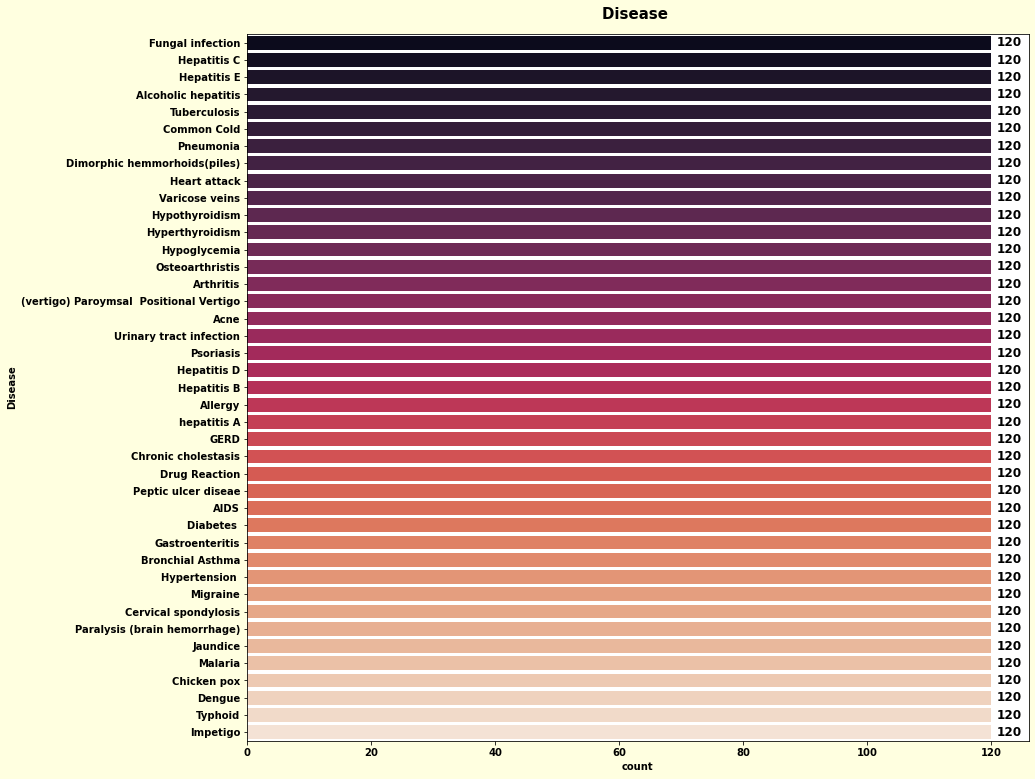

In [ ]:
plt.figure(figsize=(14,13), facecolor='lightyellow')
ax = sns.countplot(data=df, y='Disease', order=df['Disease'].value_counts().index, palette='rocket')
ax.set_title('Disease ', fontsize=15, fontweight='semibold', pad=15)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(5, 0),
        textcoords='offset points', va='center', ha='left', color = 'black', fontsize=12)

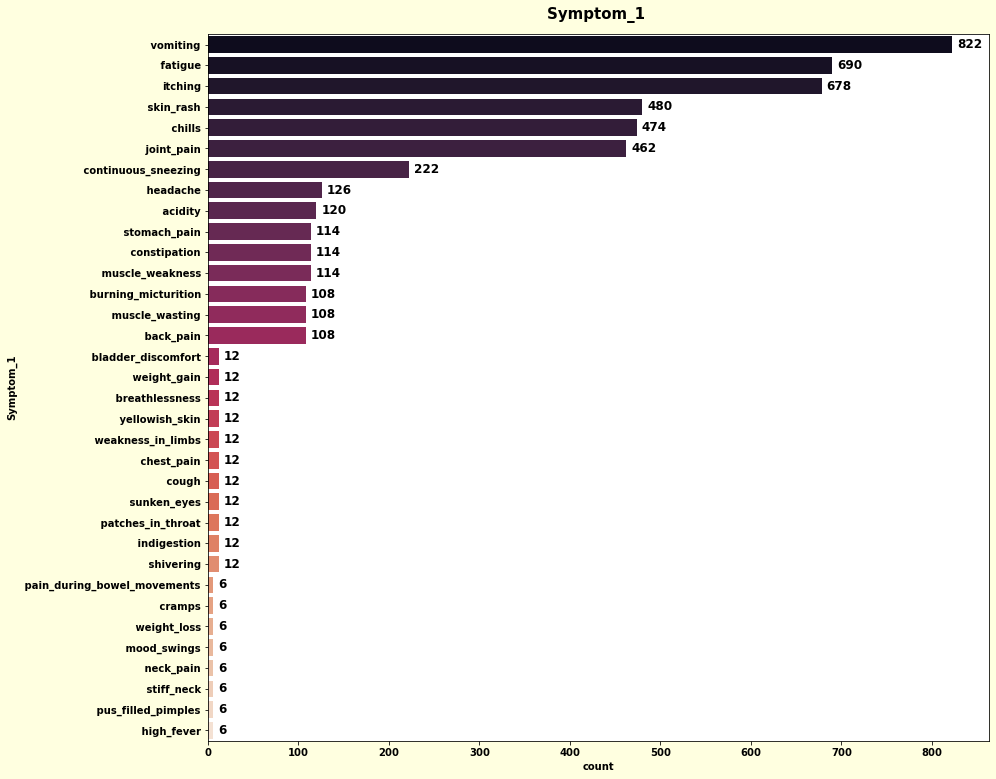

In [ ]:
plt.figure(figsize=(14,13), facecolor='lightyellow')
ax = sns.countplot(data=df, y='Symptom_1', order=df['Symptom_1'].value_counts().index, palette='rocket')
ax.set_title('Symptom_1 ', fontsize=15, fontweight='semibold', pad=15)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(5, 0),
        textcoords='offset points', va='center', ha='left', color = 'black', fontsize=12)

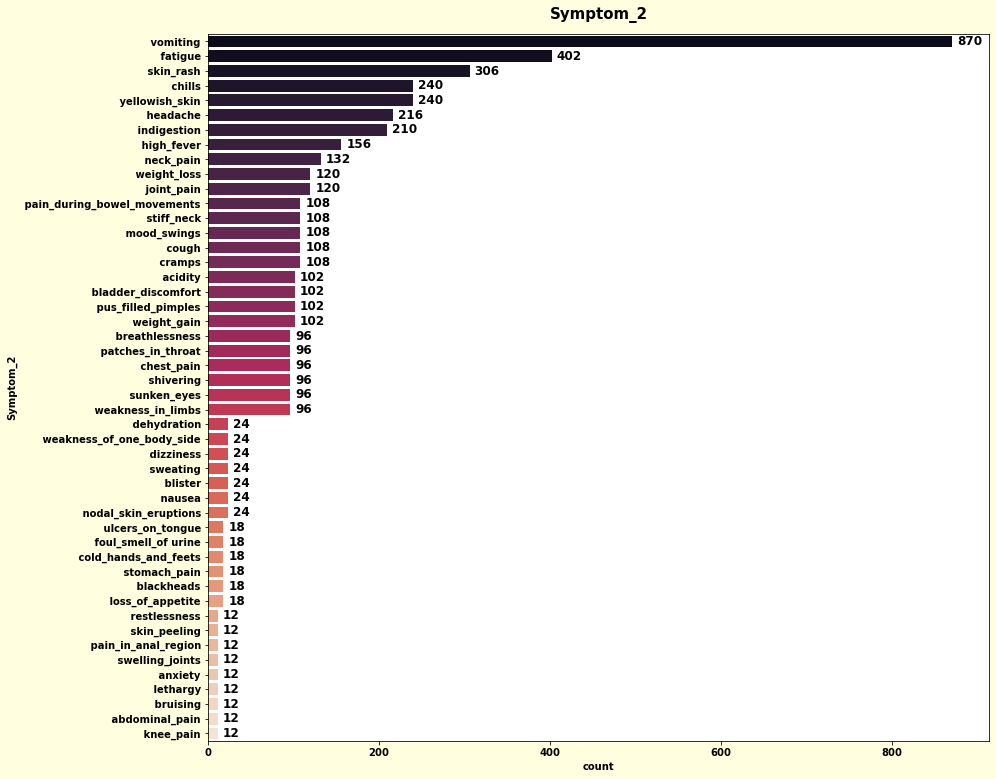

In [ ]:
plt.figure(figsize=(14,13), facecolor='lightyellow')
ax = sns.countplot(data=df, y='Symptom_2', order=df['Symptom_2'].value_counts().index, palette='rocket')
ax.set_title('Symptom_2', fontsize=15, fontweight='semibold', pad=15)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(5, 0),
        textcoords='offset points', va='center', ha='left', color = 'black', fontsize=12)

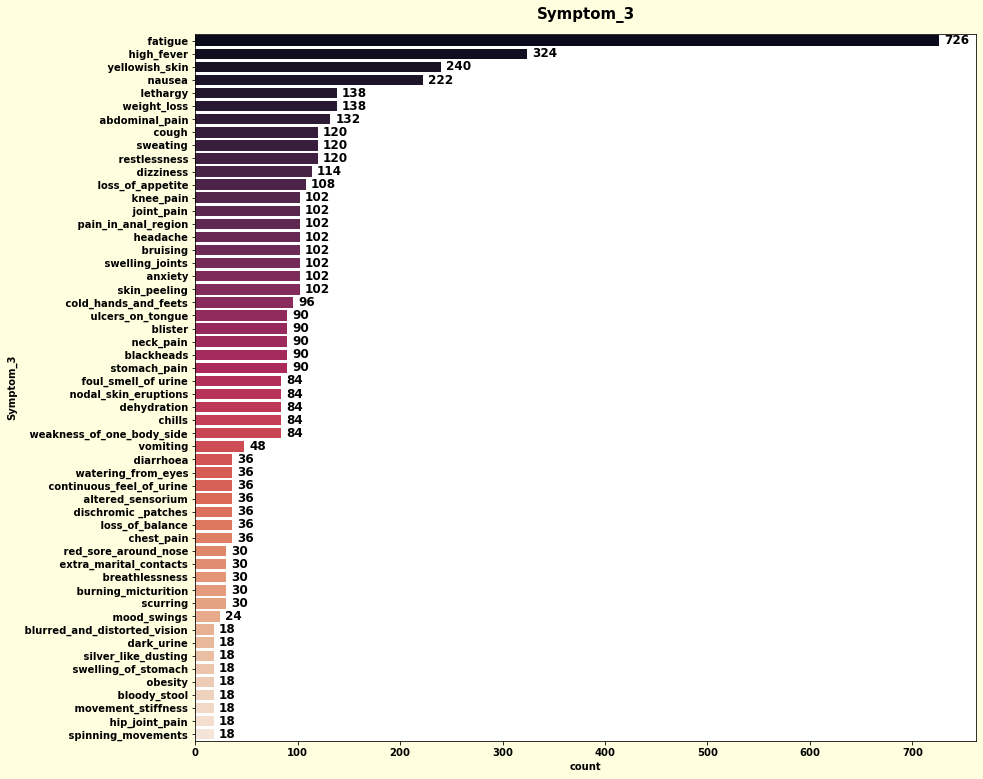

In [ ]:
plt.figure(figsize=(14,13), facecolor='lightyellow')
ax = sns.countplot(data=df, y='Symptom_3', order=df['Symptom_3'].value_counts().index, palette='rocket')
ax.set_title('Symptom_3', fontsize=15, fontweight='semibold', pad=15)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(5, 0),
        textcoords='offset points', va='center', ha='left', color = 'black', fontsize=12)

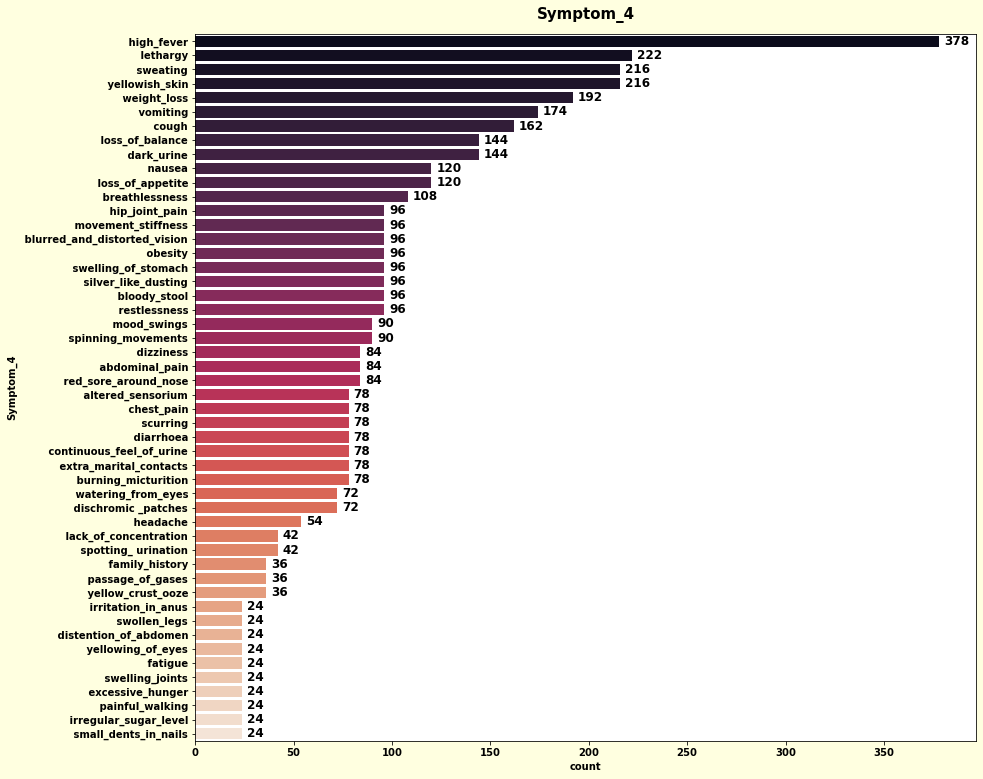

In [ ]:
plt.figure(figsize=(14,13), facecolor='lightyellow')
ax = sns.countplot(data=df, y='Symptom_4', order=df['Symptom_4'].value_counts().index, palette='rocket')
ax.set_title('Symptom_4', fontsize=15, fontweight='semibold', pad=15)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    
    plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(5, 0),
        textcoords='offset points', va='center', ha='left', color = 'black', fontsize=12)

dari hasil EDA diatas, symptomp yang paling sering dirasakan oleh pasien adalah : <br>

1.vomit<br>
2.fatigue<br> 
3.skin rash<br>
4.chills<br> 
5.yellow skin<br> 
6.high fever<br>

sebenarnya saya ingin menambahkan data dari dataset baru untuk mendukung hasil EDA diatas seperti region, umur, gender, tekanan darah, dll. tapi setelah saya pikir ulang bila data dari dataset baru tersebut ditambah, machine learning akan ada kemungkinan mendiskriminasi suatu region/ gender/ umur, dll. dan saya tidak mau itu terjadi karna akan tidak akurat hasil modelnya.

untuk EDA saya stop sampai ke symptomp 4, karna ke symptomp selanjutnya, karna banyaknya missing value tadi jadi, banyak data dengan value 0. dan hal tersebut tidak akan memberi insight yang bagus juga.

<h2>Feature Engineering</h2>

In [ ]:
X = df.drop('Disease', axis=1).copy()
y = df['Disease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3936, 17), (984, 17), (3936,), (984,))

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

In [ ]:
ordinal_encode = OrdinalEncoder()
X_train_enc = ordinal_encode.fit_transform(X_train_2)
X_test_enc = ordinal_encode.transform(X_test_2)

X_train_enc = pd.DataFrame(X_train_enc)
X_test_enc = pd.DataFrame(X_test_enc)

X_train_enc.columns = X_train_2.columns
X_test_enc.columns = X_test_2.columns

X_train_enc.head()

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,33.0,15.0,28.0,49.0,5.0,17.0,0.0,19.0,21.0,7.0,10.0,6.0,NaN,NaN,NaN,NaN,NaN
1,28.0,19.0,29.0,32.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,42.0,21.0,19.0,12.0,20.0,3.0,0.0,3.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,12.0,8.0,19.0,26.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26.0,1.0,48.0,44.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_test_enc.head()

,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,15.0,42.0,21.0,19.0,37.0,5.0,17.0,9.0,0.0,20.0,1.0,1.0,7.0,NaN,NaN,NaN,NaN
1,17.0,30.0,24.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.0,42.0,53.0,9.0,21.0,0.0,6.0,11.0,21.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28.0,47.0,0.0,42.0,7.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.0,12.0,8.0,30.0,33.0,28.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_train_final = X_train_enc.fillna(0)
X_test_final = X_test_enc.fillna(0)

In [ ]:
y_train_ohe = pd.get_dummies(y_train)
y_train_ohe

,(vertigo) Paroymsal Positional Vertigo,AIDS,Acne,Alcoholic hepatitis,Allergy,Arthritis,Bronchial Asthma,Cervical spondylosis,Chicken pox,Chronic cholestasis,...,Osteoarthristis,Paralysis (brain hemorrhage),Peptic ulcer diseae,Pneumonia,Psoriasis,Tuberculosis,Typhoid,Urinary tract infection,Varicose veins,hepatitis A
4202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4629,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_test_ohe= pd.get_dummies(y_test)

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim = X_train_final.shape[1]))
model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(y_train_ohe.shape[1],activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 41)                697       
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
early_stopping_monitor= EarlyStopping(patience=2, monitor='val_accuracy')
history = model.fit(X_train_final, y_train_ohe, batch_size=120, epochs=50, validation_split=0.3, callbacks=[early_stopping_monitor])

Epoch 1/50
23/23 [==============================] - 4s 40ms/step - loss: 4.8587 - accuracy: 0.0330 - val_loss: 3.9828 - val_accuracy: 0.0220
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 3.7643 - accuracy: 0.0276 - val_loss: 3.6298 - val_accuracy: 0.0220
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 3.5452 - accuracy: 0.0436 - val_loss: 3.4516 - val_accuracy: 0.0635
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 3.3753 - accuracy: 0.0980 - val_loss: 3.2587 - val_accuracy: 0.1202
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 3.1869 - accuracy: 0.1347 - val_loss: 3.0386 - val_accuracy: 0.1897
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 2.9452 - accuracy: 0.2388 - val_loss: 2.7596 - val_accuracy: 0.2879
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 2.6470 - accuracy: 0.3187 - val_loss: 2.4550 - val_accuracy: 0.3506
Epoch 8/50
23/23 [=

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df['diff']  = abs(history_df['loss']-history_df['val_loss'])
history_df

,loss,accuracy,val_loss,val_accuracy,epoch,diff
0,4.858674,0.033031,3.982792,0.022015,0,0.875882
1,3.764308,0.027586,3.629845,0.022015,1,0.134463
2,3.545211,0.043557,3.451552,0.063506,2,0.093659
3,3.375315,0.098004,3.258708,0.120237,3,0.116606
4,3.186876,0.134664,3.038608,0.189670,4,0.148268
5,2.945176,0.238838,2.759620,0.287892,5,0.185556
6,2.647028,0.318693,2.455042,0.350550,6,0.191986
7,2.350751,0.400000,2.192239,0.424217,7,0.158512
8,2.088824,0.459891,1.963884,0.463167,8,0.124940
9,1.867882,0.520871,1.757327,0.574090,9,0.110555


<AxesSubplot:xlabel='epoch', ylabel='loss'>

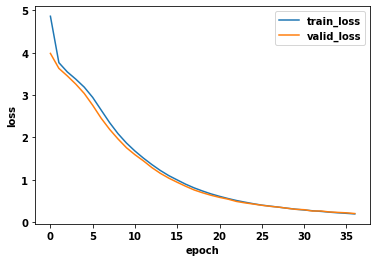

In [ ]:
sns.lineplot(data = history_df, x='epoch', y='loss', label = 'train_loss')
sns.lineplot(data = history_df, x='epoch', y='val_loss', label = 'valid_loss')

<AxesSubplot:xlabel='epoch'>

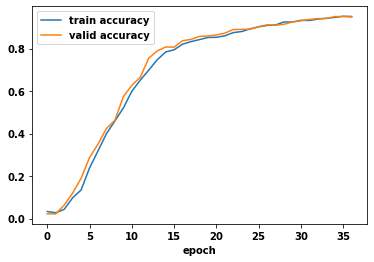

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
sns.lineplot(data = history_df, x='epoch', y=acc, label = 'train accuracy')
sns.lineplot(data = history_df, x='epoch', y=val_acc, label = 'valid accuracy')

In [ ]:
model.evaluate(X_test_final, y_test_ohe, batch_size=10, steps=10)

10/10 [==============================] - 5s 18ms/step - loss: 0.2539 - accuracy: 0.9400


[0.2539234161376953, 0.9399999976158142]

In [ ]:
prediction = model.predict_classes(X_test_final)
prediction

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([22,  1, 12,  3, 27,  9, 18,  0, 17, 26, 32, 33, 26,  3,  7,  2, 14,
       26,  3, 22, 19, 24, 28, 33,  0, 22,  2, 24,  2, 25, 38,  2, 14,  0,
        4, 29, 16,  8, 21, 13, 27, 24, 20, 36, 39, 12, 28, 40, 22, 31, 13,
       33, 31,  3,  8, 23,  6, 12, 19, 10, 14,  2, 25, 27, 31, 13, 18, 21,
       12,  1,  6, 30,  2, 10,  6, 23, 33, 18,  0, 32,  1, 16,  8, 33,  2,
       15,  8, 22,  7,  8, 18, 10,  2, 30, 14,  3, 23, 37, 14, 16, 14, 37,
       25, 21, 23, 18,  6, 36, 19, 23,  8, 13, 27, 10, 11, 19, 36, 26, 10,
       23, 31,  1, 23, 24, 12, 37, 13,  8, 14, 36, 36, 18, 26, 36, 22, 13,
        9, 11, 29, 40, 27, 38, 20, 13, 37, 14,  9, 12, 20, 11,  5, 33, 33,
       35, 18,  8, 19,  6,  9,  2, 31,  9, 35, 33, 21, 21,  7, 40,  9, 13,
        4, 18, 18, 16, 12, 25, 11, 22, 36, 22, 22,  2,  3, 34, 15, 33,  3,
       28, 14, 29, 29,  6,  7,  8, 29, 27,  3, 36, 28, 10, 40, 32, 17, 18,
       36, 16, 38, 11,  1, 39, 12, 34, 26,  1, 18, 18, 38,  9, 11,  9,  2,
       27, 19, 28, 27,  6